<a href="https://colab.research.google.com/github/arafat04/bn-hi-MT-improvement-using-llm/blob/main/prepare_dataset_and_training_llama8b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.0
tiktoken version: 0.9.0
torch version: 2.5.1
tqdm version: 4.67.1
tensorflow version: 2.18.0


In [ ]:
# !nvidia-smi

In [ ]:

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
#model_id = "meta-llama/Llama-3.2-1B-Instruct"
token = ""  # Replace with your token

# Step 1: Authenticate explicitly
from huggingface_hub import login
login(token=token)

# Step 2: Load with updated settings
tokenizer = AutoTokenizer.from_pretrained(model_id, token=token)

### Load the finetuning data

In [ ]:
file_path = "/storage/praha1/home/rahmang/llm_bn_hi/data/matched_translations_all.csv"

In [ ]:
import pandas as pd

In [ ]:
data_df = pd.read_csv(file_path)
data_df = data_df.head(200)
data_df.head()

,English,Hindi,Hindi_Transliteration,Bengali
0,it is an indoor scene,यह एक इनडोर दृश्य है,yah ek indor drishy hai,এটি একটি অভ্যন্তরীণ দৃশ্য
1,Computer screens turned on,कंप्यूटर स्क्रीन चालू,kanpyootar skrin chaaloo,কম্পিউটারের পর্দা চালু আছে
2,man has short hair,आदमी के छोटे बाल हैं,aadmi ke chhote baal hain,মানুষের চুল ছোট
3,photo album open on an adult's lap,एक वयस्क की गोद में फोटो एल्बम खुला,ek vayask ki god men photo elbam khula,কোনও বয়স্কের কোলে ফটো অ্যালবাম খোলা
4,there is a group of girls beside the black car,काली कार के पास लड़कियों का एक समूह है,kaali kaar ke paas larkiyon ka ek samooh hai,কালো গাড়ির পাশে মেয়েদের একটি দল রয়েছে


In [ ]:
train_portion = int(len(data_df) * 0.85)  # 85% for training
test_portion = int(len(data_df) * 0.1)    # 10% for testing
val_portion = len(data_df) - train_portion - test_portion  # Remaining 5% for validation

train_data = data_df[:train_portion]
test_data = data_df[train_portion:train_portion + test_portion]
val_data = data_df[train_portion + test_portion:]

In [ ]:
# train_data.head()

In [ ]:
# test_data.head()

### Few-shot Conversation

In [ ]:
from transformers import AutoTokenizer

def format_input(entry):
    # Define the conversation history
    messages = [
        {"role": "system", "content": "You are an expert on translating from Bengali to Hindi."},
        {"role": "user", "content": "Translate the following Bengali text to Hindi: খবরটা শুনে খুব খারাপ লাগলো।"},
        {"role": "assistant", "content": "खबर सुनकर बहुत दुख हुआ."},
        {"role": "user", "content": "Translate the following Bengali text to Hindi: প্রশিক্ষণ অ্যালগরিদম, পরামিতি, ন্যায্যতা সীমাবদ্বতা বা অন্যান্য প্রয়োগ পদ্ধতি এবং বৈশিষ্ট্য সম্পর্কে তথ্য।"},
        {"role": "assistant", "content": "प्रशिक्षण अल्गोरिदम, पैरामीटर्स, न्यायसंगतता सीमाएँ या अन्य अनुप्रयोग विधियों और विशेषताओं के बारे में जानकारी।"},
        {"role": "user", "content": f"Translate the following Bengali text to Hindi: {entry['Bengali']}"}
    ]

    return messages



In [ ]:
train_data.iloc[0]['Hindi']

'यह एक इनडोर दृश्य है'

In [ ]:
print(format_input(train_data.iloc[0]))

[{'role': 'system', 'content': 'You are an expert on translating from Bengali to Hindi.'}, {'role': 'user', 'content': 'Translate the following Bengali text to Hindi: খবরটা শুনে খুব খারাপ লাগলো।'}, {'role': 'assistant', 'content': 'खबर सुनकर बहुत दुख हुआ.'}, {'role': 'user', 'content': 'Translate the following Bengali text to Hindi: প্রশিক্ষণ অ্যালগরিদম, পরামিতি, ন্যায্যতা সীমাবদ্বতা বা অন্যান্য প্রয়োগ পদ্ধতি এবং বৈশিষ্ট্য সম্পর্কে তথ্য।'}, {'role': 'assistant', 'content': 'प्रशिक्षण अल्गोरिदम, पैरामीटर्स, न्यायसंगतता सीमाएँ या अन्य अनुप्रयोग विधियों और विशेषताओं के बारे में जानकारी।'}, {'role': 'user', 'content': 'Translate the following Bengali text to Hindi: এটি একটি অভ্যন্তরীণ দৃশ্য'}]


### Organizing data into training batches:

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.instruction_lengths = []
        # Pre-tokenize texts
        self.encoded_texts = []
        for i in range(len(data)):
            instruction_plus_input = format_input(data.iloc[i])
            response_text = [{"role": "assistant", "content": f"{data.iloc[i]['Hindi']}"}]
            full_text = instruction_plus_input + response_text
            # Usage example


            # Convert to Llama-3 compatible string format using HF apply_chat_template
            formatted_text_instruction_plus_input = tokenizer.apply_chat_template(
                instruction_plus_input,
                tokenize=False,
                add_generation_prompt=True
            )
            formatted_text = tokenizer.apply_chat_template(
                full_text,
                tokenize=False,
                add_generation_prompt=True
            )
            if i == 0:
                print("Formatted prompt:\n", formatted_text)



            self.encoded_texts.append(
                tokenizer.encode(formatted_text)
            )
            #for masking out the output text
            instruction_length = (len(tokenizer.encode(formatted_text_instruction_plus_input)))
            #print("instruction length",instruction_length)
            self.instruction_lengths.append(instruction_length)

    def __getitem__(self, index):
        return self.instruction_lengths[index], self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

### Custom Collate Function:

This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)



In [ ]:
#with attention mask
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device='cpu'
):
    batch_max_length = max(len(item) + 1 for instruction_length, item in batch)
    inputs_lst, targets_lst = [], []

    for instruction_length, item in batch:
        new_item = item + [pad_token_id]  # Add pad token at the end
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        inputs = torch.tensor(padded[:-1])  # Input (excluding last token)
        targets = torch.tensor(padded[1:])  # Target (shifted right)

        # Generate attention mask (1 for real tokens, 0 for padding)
        # attention_mask = (torch.tensor(padded) != pad_token_id).long()

        # Mask padding tokens in targets for loss calculation
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        targets[:instruction_length] = -100  # Ignore tokens before the instruction length

        # Truncate to `allowed_max_length`
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
            # attention_mask = attention_mask[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
        # attention_masks.append(attention_mask)

    # Stack and move to device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    # attention_mask_tensor = torch.stack(attention_masks).to(device)

    return inputs_tensor, targets_tensor


Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

In [ ]:
# inputs, targets = custom_collate_fn(batch)
# print(inputs)
# print(targets)

In [ ]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


 ### Creating data loaders for the instruction dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
import torch

if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))  # Print GPU name
    print("Total Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")  # Convert bytes to GB
    print("CUDA Capability:", torch.cuda.get_device_properties(0).major, ".", torch.cuda.get_device_properties(0).minor)
else:
    print("No GPU available, using CPU.")


Device: NVIDIA A40
Total Memory: 47.729344512 GB
CUDA Capability: 8 . 6


In [ ]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=512 # max token size for llama 3.1 8b is 2048
)

In [ ]:
# import tiktoken
# tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
#tokenizer

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 4

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

Formatted prompt:
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert on translating from Bengali to Hindi.<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the following Bengali text to Hindi: খবরটা শুনে খুব খারাপ লাগলো।<|eot_id|><|start_header_id|>assistant<|end_header_id|>

खबर सुनकर बहुत दुख हुआ.<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the following Bengali text to Hindi: প্রশিক্ষণ অ্যালগরিদম, পরামিতি, ন্যায্যতা সীমাবদ্বতা বা অন্যান্য প্রয়োগ পদ্ধতি এবং বৈশিষ্ট্য সম্পর্কে তথ্য।<|eot_id|><|start_header_id|>assistant<|end_header_id|>

प्रशिक्षण अल्गोरिदम, पैरामीटर्स, न्यायसंगतता सीमाएँ या अन्य अनुप्रयोग विधियों और विशेषताओं के बारे में जानकारी।<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the following Bengali text to Hindi: এটি একটি অভ্যন্তরীণ দৃশ্য<|eot_id|><|start_header_id|>assistant<|end_header_id|>

यह एक इनडोर दृश्य है<|eot_id|><|start_hea

In [ ]:
train_loader

In [ ]:
print("Train loader:")
count = 0
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    if count == 1:
        break
    count +=1

Train loader:
torch.Size([4, 388]) torch.Size([4, 388])
torch.Size([4, 387]) torch.Size([4, 387])


In [ ]:
print(inputs[0])


tensor([128000, 128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,
          2696,     25,   6790,    220,   2366,     18,    198,  15724,   2696,
            25,    220,   1627,  10263,    220,   2366,     19,    271,   2675,
           527,    459,   6335,    389,  67371,    505,  26316,   8115,    311,
         45080,     13, 128009, 128006,    882, 128007,    271,  28573,    279,
          2768,  26316,   8115,   1495,    311,  45080,     25,  36278,    244,
         11372,    105,  73358,  11372,    253,  42412,  36278,    114,  28025,
           223,  87648,  60008,  36278,    244,  28025,    223,  11372,    105,
         36278,    244,  50228,    108,  50228,    103,  36278,    110,  50228,
           245,  11372,    110,  28025,    233, 100278, 128009, 128006,  78191,
        128007,    271, 100979, 105800,  69258, 101391, 101185, 102875, 102223,
        100291, 102815,  85410, 102863,     13, 128009, 128006,    882, 128007,
           271,  28573,    279,   2768, 

In [ ]:
len(train_loader)

42

In [ ]:
print(len(train_loader.dataset))


170


In [ ]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

Formatted prompt:
 <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert on translating from Bengali to Hindi.<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the following Bengali text to Hindi: খবরটা শুনে খুব খারাপ লাগলো।<|eot_id|><|start_header_id|>assistant<|end_header_id|>

खबर सुनकर बहुत दुख हुआ.<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the following Bengali text to Hindi: প্রশিক্ষণ অ্যালগরিদম, পরামিতি, ন্যায্যতা সীমাবদ্বতা বা অন্যান্য প্রয়োগ পদ্ধতি এবং বৈশিষ্ট্য সম্পর্কে তথ্য।<|eot_id|><|start_header_id|>assistant<|end_header_id|>

प्रशिक्षण अल्गोरिदम, पैरामीटर्स, न्यायसंगतता सीमाएँ या अन्य अनुप्रयोग विधियों और विशेषताओं के बारे में जानकारी।<|eot_id|><|start_header_id|>user<|end_header_id|>

Translate the following Bengali text to Hindi: আকাশে সাদা মেঘ<|eot_id|><|start_header_id|>assistant<|end_header_id|>

आकाश में सफेद बादल<|eot_id|><|start_header_id|>assis

### Finetune the model

In [ ]:
# !pip install transformers==4.40.0 accelerate==0.29.3 bitsandbytes==0.43.1 tuned-lens==0.2.0

# pip install --upgrade bitsandbytes
#! pip install transformers --quiet
#pip install --upgrade transformers

In [ ]:
# from transformers import AutoConfig
# from transformers import pipeline
# import torch
# config = AutoConfig.from_pretrained(model_identifier)

# # Ensure rope_scaling has only 'type' and 'factor'
# if hasattr(config, "rope_scaling") and isinstance(config.rope_scaling, dict):
#     config.rope_scaling = {
#         "type": config.rope_scaling.get("rope_type", "linear"),  # Default to 'linear' if missing
#         "factor": config.rope_scaling.get("factor", 1.0),  # Default to 1.0 if missing
#     }

# # Find the best available device
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # Use GPU if available, otherwise use CPU
# print("device: ", device)
# # Load model with updated config
# #device_map="auto",  # Let Hugging Face manage memory
# llm = pipeline(model=model_identifier,token=token,device_map="auto", config=config)


In [ ]:
print(model_id)

meta-llama/Meta-Llama-3.1-8B-Instruct


In [ ]:
from transformers import AutoModelForCausalLM
import torch

# Load the model in FP16
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16,  # Use FP16
    token=token,
    load_in_8bit=True,  # Optional: Use 8-bit quantization
)

2025-02-16 23:35:17.922904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739745318.575730  183887 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739745318.776857  183887 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 23:35:20.246592: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `Bi

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear8bitLt(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): Lla

In [ ]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)


In [ ]:
import torch

if torch.cuda.is_available():
    # Print GPU name and total memory
    print("Device:", torch.cuda.get_device_name(0))
    print("Total Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")
    print("CUDA Capability:", torch.cuda.get_device_properties(0).major, ".", torch.cuda.get_device_properties(0).minor)

    # Print current memory usage
    print("Allocated Memory:", torch.cuda.memory_allocated(0) / 1e9, "GB")  # Memory currently in use by tensors
    print("Cached Memory:", torch.cuda.memory_reserved(0) / 1e9, "GB")  # Memory reserved by PyTorch
    print("Free Memory:", torch.cuda.memory_reserved(0) - torch.cuda.memory_allocated(0) / 1e9, "GB")  # Free memory
else:
    print("No GPU available, using CPU.")

Device: NVIDIA A40
Total Memory: 47.729344512 GB
CUDA Capability: 8 . 6
Allocated Memory: 9.086731776 GB
Cached Memory: 9.141485568 GB
Free Memory: 9141485558.913269 GB


#### Before we start finetuning the model, let's see how it performs on one of the validation data


In [ ]:
torch.manual_seed(123)

input_text = format_input(val_data.iloc[0])
print(input_text)

[{'role': 'system', 'content': 'You are an expert on translating from Bengali to Hindi.'}, {'role': 'user', 'content': 'Translate the following Bengali text to Hindi: খবরটা শুনে খুব খারাপ লাগলো।'}, {'role': 'assistant', 'content': 'खबर सुनकर बहुत दुख हुआ.'}, {'role': 'user', 'content': 'Translate the following Bengali text to Hindi: প্রশিক্ষণ অ্যালগরিদম, পরামিতি, ন্যায্যতা সীমাবদ্বতা বা অন্যান্য প্রয়োগ পদ্ধতি এবং বৈশিষ্ট্য সম্পর্কে তথ্য।'}, {'role': 'assistant', 'content': 'प्रशिक्षण अल्गोरिदम, पैरामीटर्स, न्यायसंगतता सीमाएँ या अन्य अनुप्रयोग विधियों और विशेषताओं के बारे में जानकारी।'}, {'role': 'user', 'content': 'Translate the following Bengali text to Hindi: আকাশে সাদা মেঘ'}]


In [ ]:
input_ids = tokenizer.apply_chat_template(
    format_input(val_data.iloc[0]),
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


आकाश में सफेद बादल


In [ ]:
# # with transformers pipeline
# prompt = llm.tokenizer.apply_chat_template(format_input(val_data.iloc[0]), tokenize=False, add_generation_prompt=True)

# generation = llm(prompt, max_new_tokens = 2048)

# new_text = generation[0]['generated_text'][len(prompt):]

# print(new_text)
# print()

romanize the Hindi translation:

In [ ]:

# with open("/storage/praha1/home/rahmang/llm_bn_hi/data/devanagari-to-roman-script-transliteration/output_val1.txt", "w") as file:
#     file.write(new_text)


In [ ]:
file_path = "/storage/praha1/home/rahmang/llm_bn_hi/data/devanagari-to-roman-script-transliteration/output_val1.txtOUTPUT"

with open(file_path, "r", encoding="utf-8") as file:
    content = file.read()  # Read the entire file
    print(content)  # Print the file content


kating bord saphed


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [ ]:


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


import torch

def generate_and_print_sample(model, tokenizer, device, start_context, max_new_tokens=50):
    """
    Generate and print a sample text using the model.

    Args:
        model: The trained model.
        tokenizer: The tokenizer for encoding/decoding text.
        device: The device (e.g., "cuda" or "cpu").
        start_context (str): The starting context for text generation.
        max_new_tokens (int): Maximum number of tokens to generate.
    """
    model.eval()  # Set the model to evaluation mode

    # Encode the starting context using chat template
    input_ids = tokenizer.apply_chat_template(
        start_context,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    # Generate text
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.8,
            eos_token_id=terminators
        )

    # Extract only the newly generated tokens
    response = outputs[0][input_ids.shape[-1]:]

    # Decode the response using the chat template
    decoded_text = tokenizer.decode(response, skip_special_tokens=True)

    # Print the generated text
    print(decoded_text.replace("\n", " "))  # Compact print format

    model.train()  # Set the model back to training mode



def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))




def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # Forward pass returns CausalLMOutputWithPast
    outputs = model(input_batch)

    # Extract logits tensor (shape: [batch_size, seq_len, vocab_size])
    logits = outputs.logits

    # Debug: Check for NaN or inf in logits
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        print("Logits contain NaN or inf values!")

    # Reshape for cross-entropy: (batch*seq_len, vocab_size)
    logits_flat = logits.view(-1, logits.size(-1))

    # Reshape targets: (batch*seq_len)
    targets_flat = target_batch.view(-1)

    # Debug: Check for NaN or inf in targets
    if torch.isnan(targets_flat).any() or torch.isinf(targets_flat).any():
        print("Targets contain NaN or inf values!")

    # Calculate loss (ignore padding tokens marked with -100)
    loss = torch.nn.functional.cross_entropy(
        logits_flat,
        targets_flat,
        ignore_index=-100  # Ensure this matches the padding token ID
    )

    # Debug: Check for NaN or inf in loss
    if torch.isnan(loss).any() or torch.isinf(loss).any():
        print("Loss is NaN or inf!")

    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))  # Avoid exceeding total batches

    for i, (input_batch, target_batch) in enumerate(data_loader):  # Unpack  values
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch,model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss / num_batches





def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    n_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
    warmup_steps,
    initial_lr=3e-05,
    min_lr=1e-6
):
    # Initialize lists to track training and validation losses, tokens seen, and learning rates
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []

    # Initialize counters for tokens seen and global steps
    tokens_seen, global_step = 0, -1

    # Get the peak learning rate from the optimizer
    peak_lr = optimizer.param_groups[0]["lr"]

    # Calculate the total number of training steps (iterations)
    total_training_steps = len(train_loader) * n_epochs

    # Calculate the learning rate increment during the warmup phase
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    # Training loop over epochs
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode

        # Iterate over batches in the training data loader
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset gradients
            global_step += 1  # Increment global step counter

            # Adjust the learning rate based on the current phase (warmup or cosine annealing)
            if global_step < warmup_steps:
                # Warmup phase: linearly increase the learning rate
                lr = initial_lr + global_step * lr_increment
            else:
                # Cosine annealing phase: adjust the learning rate using a cosine schedule
                progress = ((global_step - warmup_steps) / (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            # Apply the calculated learning rate to the optimizer
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)  # Track the learning rate

            # Move input and target batches to the device
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # Debug: Check for NaN or inf in input and target batches
            if torch.isnan(input_batch).any() or torch.isinf(input_batch).any():
                print("Input batch contains NaN or inf values!")
            if torch.isnan(target_batch).any() or torch.isinf(target_batch).any():
                print("Target batch contains NaN or inf values!")

            # Forward pass
            outputs = model(input_batch)
            logits = outputs.logits

            # Debug: Check for NaN or inf in logits
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                print("Logits contain NaN or inf values!")

            # Calculate the loss for the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            if torch.isnan(loss).any() or torch.isinf(loss).any():
                print("Loss is NaN or inf!")

            # Backpropagate the loss
            loss.backward()

            # Apply gradient clipping after the warmup phase to avoid exploding gradients
            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update model parameters
            optimizer.step()
            tokens_seen += input_batch.numel()  # Track the number of tokens seen

            # Evaluate the model periodically
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)  # Track training loss
                val_losses.append(val_loss)  # Track validation loss
                track_tokens_seen.append(tokens_seen)  # Track tokens seen

                # Print training and validation loss
                print(
                    f"Ep {epoch+1} (Iter {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

                # Generate and print a sample text
                generate_and_print_sample(model, tokenizer, device, start_context)

    # Return the tracked metrics
    return train_losses, val_losses, track_tokens_seen, track_lrs

In [ ]:
device

device(type='cuda')

In [ ]:
!nvidia-smi

Sun Feb 16 23:37:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:81:00.0 Off |                    0 |
|  0%   46C    P0            114W /  300W |    9185MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**the initial training and validation set loss before we start training (as in previous chapters, the goal is to minimize the loss**

In [ ]:
#model.to(device) #`.to` is not supported for `8-bit` bitsandbytes models. Please use the model as it is,
#since the model has already been set to the correct devices and casted to the correct `dtype`.
#if we loaded the usual model, then need to do: model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.5517578125
Validation loss: 1.6702473958333333


In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sun Feb 16 23:37:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:81:00.0 Off |                    0 |
|  0%   50C    P0            197W /  300W |    9103MiB /  46068MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# from accelerate import Accelerator

# # Initialize Accelerator with FP16
# accelerator = Accelerator(mixed_precision="fp16")

# # Prepare model, optimizer, and data loader
# model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

### parameter efficient fine tuning with LoRA

In [ ]:
import torch
import torch.nn as nn
import math

class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        self.A = nn.Parameter(torch.empty(in_dim, rank))
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        # Ensure LoRA parameters are on the same device as x
        device = x.device
        A = self.A.to(device).to(x.dtype)
        B = self.B.to(device).to(x.dtype)

        return self.alpha * (x @ A @ B)



class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha, device=None):
        super().__init__()
        self.linear = linear.to(device)
        self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha).to(device)

    def forward(self, x):
        return self.linear(x) + self.lora(x)


def replace_linear_with_lora(model, rank, alpha, device):
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            setattr(model, name, LinearWithLoRA(module, rank, alpha).to(device))
        else:
            replace_linear_with_lora(module, rank, alpha, device)



**Before we apply the LinearWithLoRA layer upgrades, we first freeze the original model
parameters:**

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")
for param in model.parameters():
    param.requires_grad = False
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 1,050,939,392
Total trainable parameters after: 0


In [ ]:
#we use the replace_linear_with_lora to replace the Linear layers:
replace_linear_with_lora(model, rank=8, alpha=8,device=device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 22,030,336


In [ ]:
!nvidia-smi

Sun Feb 16 23:37:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:81:00.0 Off |                    0 |
|  0%   49C    P0            101W /  300W |    9179MiB /  46068MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
device

device(type='cuda')

In [ ]:
import time
model = model
start_time = time.time()

torch.manual_seed(123)
#model.to(device)
peak_lr = 5e-4
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1)
n_epochs = 15

total_steps = len(train_loader) * n_epochs
warmup_steps = int(0.2 * total_steps)
print(warmup_steps)

train_losses, val_losses, tokens_seen, lrs = train_model(
model, train_loader, val_loader, optimizer, device, n_epochs=n_epochs,
eval_freq=5, eval_iter=1, start_context=format_input(val_data.iloc[0]),
tokenizer=tokenizer, warmup_steps=warmup_steps,
initial_lr=1e-5, min_lr=1e-5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

126


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000000): Train loss 1.872, Val loss 1.523
आकाश में सफेद बादल


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000005): Train loss 0.935, Val loss 0.793
parableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparableparable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000010): Train loss 1.294, Val loss 0.799
parable blue clouds


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000015): Train loss 1.093, Val loss 1.285
parable सम्प्रत्के में सफेद मे�घे आदमी जाता है


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000020): Train loss 4.891, Val loss 5.219
ी में के खी से आदमी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000025): Train loss 12.625, Val loss 12.609
104 CENT164(mi Cent54mansemic Cent Central CENT104 brig104 brig104 CENT Cent CENT Cent CENT CENT Cent Hag Giz Cent  httpsvik Cent Hag Centanda Cent  Cent Cent Cent Cent CENT https202 CENTparableparable Cent14ندقemic104


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000030): Train loss 9.109, Val loss 9.203
           क         म   एक                               क        


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000035): Train loss 7.582, Val loss 7.719



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 1 (Iter 000040): Train loss 7.598, Val loss 7.352
assistantassistantassistantassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000045): Train loss 7.969, Val loss 7.582
ी  े    ली  े केड    ेाassistant     वले   प क  ऱ ही क  े     लकassistantी की  ै कैी की  न  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000050): Train loss 7.535, Val loss 7.230
 मीलassistant खीलassistantैकassistantassistantीलassistantंग़ींगैक्सassistantassistant़क्स मैक हारतassistantारत़कंगassistant कीलैंassistantैं चलassistantारतील़क्रक


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000055): Train loss 6.598, Val loss 6.480
 क कassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000060): Train loss 6.203, Val loss 5.668
assistantार  ा्र  ्र


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000065): Train loss 5.082, Val loss 4.746
assistantीी क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000070): Train loss 5.535, Val loss 4.867
assistantेassistantassistantर मassistantassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000075): Train loss 4.863, Val loss 4.844
 एक ब म व


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 2 (Iter 000080): Train loss 5.105, Val loss 4.711
assistantparableassistant परे बparableassistant्ररparable बassistantparable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000085): Train loss 4.582, Val loss 4.500
 कीparableassistantीparable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000090): Train loss 4.648, Val loss 4.520
ालेड


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000095): Train loss 5.145, Val loss 4.949
 मparableे मassistantassistantारassistant परparableparableparableानानेतparableील


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000100): Train loss 4.715, Val loss 4.492
assistant  parable कassistant की क क केलparableे    ी क छ हassistantassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000105): Train loss 4.613, Val loss 4.785
 पा म ह परparableassistantparable क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000110): Train loss 4.875, Val loss 4.777
parableassistantारassistantगassistantparableassistantparableparableेे कassistantparable परassistantीparableीीparableीassistantparable़डparableेारassistant कassistantparableassistantparableassistantारे


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000115): Train loss 4.887, Val loss 4.594
ारतानparable च सम  ेार


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000120): Train loss 4.762, Val loss 4.559
ारै   परassistantassistantassistantारैारassistantassistantा स क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 3 (Iter 000125): Train loss 4.711, Val loss 4.461
 पराथे परparable द द क   ब क बparableparableparable परparableम पर ह पर परा


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000130): Train loss 7.773, Val loss 7.133
ोज लुरेकोजोजोजेकेकेक लोज लोज लेकेकोजोजेक लोजेकेकेकेकोजोजोजेक्शनोजोजुर्शनागेकेक ल्शन्शनेकोजेकागेकेकागोज


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000135): Train loss 10.844, Val loss 9.594
ागाग्शनागाग लेकाग ल्शनागागेक्शनेकागोजाग लेकाग्शनागागागागाग लाग्शनाग लागुरुराग्शन लागदाग ल लागेक्शन्शन्शनागेक


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000140): Train loss 11.469, Val loss 9.828
 लुर ल ल ल ल ऊपर लददय ऊपरदुरय लयिजक ऊपर ऊपर ल सभयय लयागदंदरय सभ ल ल लदंडीुर ऊपर लीय लयम अ ऊपरुराग


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000145): Train loss 10.141, Val loss 9.695
 लुर लदंडंजद लुर ओरिजदद लांिजिजय लयांद लांयिज ऊपरुरजंदरुरमककयिंकद ऊपरंड ऊपरिजय ऊपरयययमदद


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000150): Train loss 10.594, Val loss 8.969
ाँंदर अम लुर लंडंडिकिंाँ ल अाण भ ओरीुरवदकीांीिकांकुरव ल लुरंदरंडुर तमममंडिंाण तुरंडांुरिकुर


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000155): Train loss 10.266, Val loss 8.234
तक्मककददवदीवोदमिं अदम त्मकिंकममिकवाँ तक्टांंडमकी भकम भबीांदिं भ ओर टबी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000160): Train loss 9.039, Val loss 7.613
ाँंबी मीाँीाँत तीिकांमी़द्म ल क की भी क्मीीिंी भिक त तीकतीीिंी क कीी एसी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 4 (Iter 000165): Train loss 8.094, Val loss 7.160
ीीीीकतीां मवीीी टवक्सुट भंब ट वीी ट वी म क एस मीीी कीीीीी क कीीुट ह


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000170): Train loss 7.891, Val loss 6.805
 कीीाँीुट क लटीीट टी लती


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000175): Train loss 6.910, Val loss 6.504
 मी क ह कीक टचीी ह भी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000180): Train loss 7.336, Val loss 6.238
 ह क क्स


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000185): Train loss 7.145, Val loss 6.000
 क टंबी ह हीें वीम एक क मी कीि


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000190): Train loss 6.566, Val loss 5.793



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000195): Train loss 6.168, Val loss 5.605



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000200): Train loss 6.688, Val loss 5.438
 ऱ  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 5 (Iter 000205): Train loss 5.953, Val loss 5.293
ांीassistant ल


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000210): Train loss 5.727, Val loss 5.168
 क सफ   क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000215): Train loss 6.473, Val loss 5.059



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000220): Train loss 6.141, Val loss 4.965
assistant कारतक


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000225): Train loss 5.590, Val loss 4.871
ाल  िीी क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000230): Train loss 6.785, Val loss 4.785
 ल क  assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000235): Train loss 5.223, Val loss 4.707
ी  assistantारत   कassistantी      ेद़ी  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000240): Train loss 4.832, Val loss 4.645
 कassistant एकाल    ें  ्रक ल एक


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000245): Train loss 6.059, Val loss 4.594
assistant  assistantassistantassistant     कassistantassistantें   क  ें ह व  assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 6 (Iter 000250): Train loss 5.629, Val loss 4.555
ें


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000255): Train loss 5.312, Val loss 4.516
ालेद केंीे एकassistant्र


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000260): Train loss 5.324, Val loss 4.465
 ह


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000265): Train loss 5.141, Val loss 4.422
 क स क  ें  assistantीassistant एक  ें


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000270): Train loss 4.703, Val loss 4.383



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000275): Train loss 5.406, Val loss 4.352
  े परेालेassistant  े  assistant क ख   क कassistantड क म्र कील   म परीत परी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000280): Train loss 4.906, Val loss 4.324
ेे


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000285): Train loss 5.547, Val loss 4.305



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 7 (Iter 000290): Train loss 4.566, Val loss 4.293
ी क के स


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000295): Train loss 4.430, Val loss 4.273
assistant मीी   मीें  े


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000300): Train loss 4.621, Val loss 4.266
़क कील हारassistant कडassistant  ी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000305): Train loss 4.363, Val loss 4.246
assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000310): Train loss 4.637, Val loss 4.238
parable क ह म


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000315): Train loss 4.402, Val loss 4.227



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000320): Train loss 4.516, Val loss 4.207
assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000325): Train loss 4.746, Val loss 4.199
 कassistant पराेparableassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000330): Train loss 4.305, Val loss 4.199
 क  parable पर म


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 8 (Iter 000335): Train loss 4.387, Val loss 4.195
    parableेी क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000340): Train loss 4.117, Val loss 4.184
ी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000345): Train loss 4.156, Val loss 4.172
assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000350): Train loss 4.613, Val loss 4.172
     क स


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000355): Train loss 4.105, Val loss 4.168
 क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000360): Train loss 4.242, Val loss 4.168
ार परी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000365): Train loss 4.605, Val loss 4.172
assistantी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000370): Train loss 4.391, Val loss 4.168
       नेी      assistant काेीैे क  ा के क कारparable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 9 (Iter 000375): Train loss 4.129, Val loss 4.164
assistant पाे


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000380): Train loss 4.344, Val loss 4.164
assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000385): Train loss 4.449, Val loss 4.168
 एक की कालेी कassistantाassistantेंparable नparable मparable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000390): Train loss 4.945, Val loss 4.164
assistant   परीलाी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000395): Train loss 4.527, Val loss 4.160
ाथ ख


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000400): Train loss 4.949, Val loss 4.156
  assistant्सassistantassistant   नेी क्र


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000405): Train loss 4.527, Val loss 4.156



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000410): Train loss 4.691, Val loss 4.160
 कें  ैी


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 10 (Iter 000415): Train loss 4.500, Val loss 4.156
assistantी कassistant एक ख कारparableी  parable   क क   ह  ेा ह     कैाले ब


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000420): Train loss 5.117, Val loss 4.145
parable स क कassistant  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000425): Train loss 4.203, Val loss 4.133



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000430): Train loss 4.434, Val loss 4.125
ाल


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000435): Train loss 4.324, Val loss 4.125
parable परे खparableassistantेारparableीassistant पालड प ह  ाथ न कारparable स   कassistantे


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000440): Train loss 4.820, Val loss 4.121
assistant क   नassistant एक  assistantाल बा


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000445): Train loss 4.094, Val loss 4.125
assistant  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000450): Train loss 4.621, Val loss 4.125
assistantassistant क  ी प क़काले


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000455): Train loss 4.293, Val loss 4.129
ाीलparableassistantी वparableassistant्क क क सडा की  parable क  े्र हे    ालassistantparableे


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 11 (Iter 000460): Train loss 4.484, Val loss 4.129
ील कparableassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000465): Train loss 4.035, Val loss 4.129
्कparableै नparable कparableें


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000470): Train loss 4.770, Val loss 4.129



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000475): Train loss 4.344, Val loss 4.121
 बीै एक


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000480): Train loss 4.297, Val loss 4.117
  ेassistantparable नassistantीी हेassistantassistantparableparableार  ीassistant   क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000485): Train loss 4.105, Val loss 4.121
  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000490): Train loss 4.301, Val loss 4.121
  ें केदassistant क़कassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000495): Train loss 4.312, Val loss 4.125
़क  parableे


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 12 (Iter 000500): Train loss 3.938, Val loss 4.129
assistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000505): Train loss 4.043, Val loss 4.129
  ेparable्रार ख क म


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000510): Train loss 4.168, Val loss 4.133
ाल़कparableassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000515): Train loss 4.148, Val loss 4.137
assistantा


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000520): Train loss 4.188, Val loss 4.137
assistant  parable क प़क    े


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000525): Train loss 4.215, Val loss 4.141
 क प


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000530): Train loss 4.289, Val loss 4.137
assistantparable प


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000535): Train loss 4.621, Val loss 4.137
 प में क कparable  parable क पर कassistant क्रार


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000540): Train loss 4.414, Val loss 4.133
   क परेेाे केदाल्त


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 13 (Iter 000545): Train loss 4.121, Val loss 4.133
  ीassistant क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000550): Train loss 4.270, Val loss 4.129
parableparableparable सassistantparableparableार म ह


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000555): Train loss 4.172, Val loss 4.129
ालparableी सparable प माल बparableाार


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000560): Train loss 4.578, Val loss 4.129
parable      assistantाल स


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000565): Train loss 4.699, Val loss 4.129
ाassistantेassistant क  parable  ड


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000570): Train loss 4.137, Val loss 4.129
parableी  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000575): Train loss 4.113, Val loss 4.129
 नparableassistantपparableे्कparableेparableassistant पर    assistant्र ब हे कै प एक एक क मे


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000580): Train loss 4.523, Val loss 4.129
parableassistant


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 14 (Iter 000585): Train loss 4.238, Val loss 4.129
े सparableाराथ


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000590): Train loss 4.113, Val loss 4.129
़कassistantassistantै पर


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000595): Train loss 4.293, Val loss 4.129
ार म क


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000600): Train loss 4.223, Val loss 4.129



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000605): Train loss 4.242, Val loss 4.129
parable  ी च


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000610): Train loss 4.504, Val loss 4.129



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000615): Train loss 4.367, Val loss 4.129
 ह  ड


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000620): Train loss 4.441, Val loss 4.129
assistant्का़काथparable      parableाparable


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ep 15 (Iter 000625): Train loss 4.453, Val loss 4.129
ीाड  ीड   परेद
Training completed in 17.00 minutes.


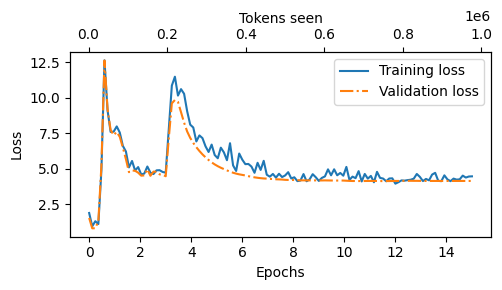

In [ ]:
epochs_tensor = torch.linspace(0, n_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
input_ids = tokenizer.apply_chat_template(
    format_input(val_data.iloc[0]),
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


assistantी हassistantassistantीेassistantassistantparableे क क



assistantparable पparable


